In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
head_dim = 8
theta_base = 10_000
context_length = 32
batch_size, num_heads, seq_len = 2, 2, 16

dtype = torch.float32

In [3]:
freq_exponents = torch.arange(0, head_dim, 2, dtype=dtype) / head_dim
inv_freq = 1.0 / (theta_base ** freq_exponents)

print("inv_freq shape:", inv_freq.shape)
print(inv_freq)

inv_freq shape: torch.Size([4])
tensor([1.0000, 0.1000, 0.0100, 0.0010])


In [4]:
# Position indices
positions = torch.arange(context_length, dtype=dtype)
print("positions shape:", positions.shape)
print(positions)

positions shape: torch.Size([32])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31.])


In [5]:
print(positions[:, None].shape)
print(inv_freq[None, :].shape)

torch.Size([32, 1])
torch.Size([1, 4])


In [6]:
# Outer product → angles (context_length, head_dim // 2)
angles_half = positions[:, None] * inv_freq[None, :]
print("angles_half shape:", angles_half.shape)
#print(angles_half)

# Duplicate to full head_dim
angles = torch.cat([angles_half, angles_half], dim=-1)

print("angles shape:", angles.shape)
print(angles[4:6, :])  # Print first two rows of angles

angles_half shape: torch.Size([32, 4])
angles shape: torch.Size([32, 8])
tensor([[4.0000e+00, 4.0000e-01, 4.0000e-02, 4.0000e-03, 4.0000e+00, 4.0000e-01,
         4.0000e-02, 4.0000e-03],
        [5.0000e+00, 5.0000e-01, 5.0000e-02, 5.0000e-03, 5.0000e+00, 5.0000e-01,
         5.0000e-02, 5.0000e-03]])


In [7]:
# # Shape: (seq_len, head_dim//2)
# angles_half = positions[:, None] * inv_freq[None, :]

# # Interleave: expand to (seq_len, head_dim)
# angles = torch.zeros(context_length, head_dim, dtype=dtype)
# angles[:, 0::2] = angles_half
# angles[:, 1::2] = angles_half

# print("angles shape:", angles.shape)
# print(angles[4:6, :])  # Print first two rows of angles

In [8]:
cos = torch.cos(angles)
sin = torch.sin(angles)

print("cos shape:", cos.shape)
print("sin shape:", sin.shape)

cos shape: torch.Size([32, 8])
sin shape: torch.Size([32, 8])


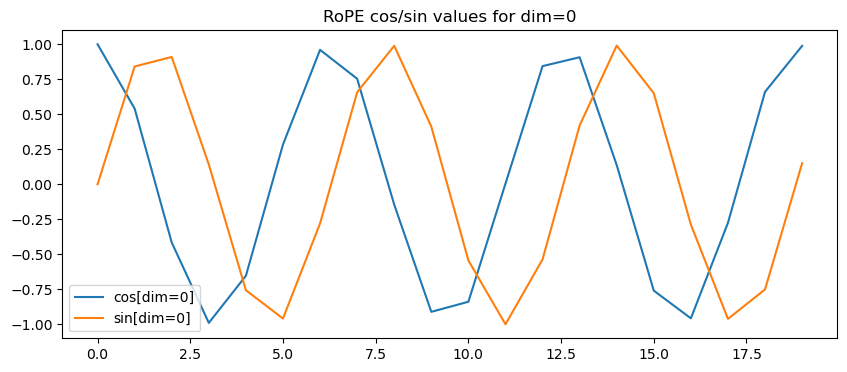

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(cos[:20, 0].numpy(), label="cos[dim=0]")
plt.plot(sin[:20, 0].numpy(), label="sin[dim=0]")
plt.legend()
plt.title("RoPE cos/sin values for dim=0")
plt.show()

In [10]:
x = torch.randn(batch_size, num_heads, seq_len, head_dim)
print("Input shape:", x.shape)
print(x[:1, :2, :1, :])  # Print a small slice of x
print("Before RoPE:", x[0, 0, 0])

Input shape: torch.Size([2, 2, 16, 8])
tensor([[[[-0.4940,  0.2771, -1.0356,  0.5023, -0.6859, -0.0511,  1.4347,
           -0.2125]],

         [[-0.6378, -0.8337, -0.5336,  0.0307,  0.3358, -2.0787,  0.4256,
           -0.2482]]]])
Before RoPE: tensor([-0.4940,  0.2771, -1.0356,  0.5023, -0.6859, -0.0511,  1.4347, -0.2125])


In [11]:
x1 = x[..., : head_dim // 2] # First half of head_dim
x2 = x[..., head_dim // 2 :] # Second half of head_dim

print("x1 shape:", x1.shape)
print("x2 shape:", x2.shape)

x1 shape: torch.Size([2, 2, 16, 4])
x2 shape: torch.Size([2, 2, 16, 4])


In [12]:
## Matching the shapes for broadcasting
# cos: (context_length, head_dim) -> (1, 1, context_length, head_dim)
# x1, x2: (batch_size, num_heads, seq_len, head_dim

cos_b = cos[:seq_len].unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, head_dim)
sin_b = sin[:seq_len].unsqueeze(0).unsqueeze(0)

print("cos_b shape:", cos_b.shape)
print("sin_b shape:", sin_b.shape)

cos_b shape: torch.Size([1, 1, 16, 8])
sin_b shape: torch.Size([1, 1, 16, 8])


In [13]:
# Rotation: [x1, x2] → [-x2, x1]
rotated = torch.cat([-x2, x1], dim=-1)

# Apply RoPE
x_rope = (x * cos_b) + (rotated * sin_b)

print("After RoPE shape:", x_rope.shape)

After RoPE shape: torch.Size([2, 2, 16, 8])


In [14]:
print("Before RoPE (pos=5):", x[0, 0, 5])
print("After RoPE  (pos=5):", x_rope[0, 0, 5])

Before RoPE (pos=5): tensor([-0.4130,  0.7717,  0.5626,  1.3527, -0.0757, -0.6508,  2.2013, -0.1123])
After RoPE  (pos=5): tensor([-0.1898,  0.9893,  0.4519,  1.3533,  0.3746, -0.2011,  2.2267, -0.1055])
